In [ ]:
# GANs（对抗生成网络）生成假人脸，训练生成器

import tensorflow as tf
from tensorflow.keras.layers import Input, Reshape, Dropout, Dense
from tensorflow.keras.layers import Flatten, BatchNormalization
from tensorflow.keras.layers import Activation, ZeroPadding2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam

import numpy as np
from PIL import Image
from tqdm import tqdm

import os
import time
import matplotlib.pyplot as plt

In [ ]:
# 设定训练参数

GENERATE_RES = 3 # 设定生成器的分辨率
GENERATE_SQUARE = 32 * GENERATE_RES
IMAGE_CHANNELS = 3

PREVIEW_ROWS = 4 # 设定预览图片的尺寸
PREVIEW_COLS = 7
PREVIEW_MARGIN = 16

SEED_SIZE = 100

# 其他参数
DATA_PATH = '/content/images'
EPOCHS = 50
BATCH_SIZE = 32
BUFFER_SIZE = 60000

In [ ]:
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)

In [ ]:
# 加载图片进行预处理，并保存为二进制数据，方便重用
training_binary_path = os.path.join(DATA_PATH,
        f'training_data_{GENERATE_SQUARE}_{GENERATE_SQUARE}.npy')

print(f"Looking for file: {training_binary_path}")

if not os.path.isfile(training_binary_path):
  start = time.time()
  print("Loading training images...")

  training_data = []
  faces_path = DATA_PATH
  for filename in tqdm(os.listdir(faces_path)):
      path = os.path.join(faces_path,filename)
      image = Image.open(path).resize((GENERATE_SQUARE,
            GENERATE_SQUARE),Image.ANTIALIAS)
      training_data.append(np.asarray(image))
  training_data = np.reshape(training_data,(-1,GENERATE_SQUARE,
            GENERATE_SQUARE,IMAGE_CHANNELS))
  training_data = training_data.astype(np.float32)
  training_data = training_data / 127.5 - 1.


  print("Saving training image binary...")
  np.save(training_binary_path,training_data)
  elapsed = time.time()-start
  print (f'Image preprocess time: {hms_string(elapsed)}')
else:
  print("Loading previous training pickle...")
  training_data = np.load(training_binary_path)

  1%|          | 43/7864 [00:00<00:18, 423.65it/s]

Looking for file: /content/images/training_data_96_96.npy
Loading training images...


100%|██████████| 7864/7864 [00:13<00:00, 575.10it/s]


Saving training image binary...
Image preprocess time: 0:00:17.68


In [ ]:
# 转为tensorflow数据集对象，方便将图片批次载入模型训练
train_dataset = tf.data.Dataset.from_tensor_slices(training_data).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
# 创建生成器模型
def build_generator(seed_size, channels):
  model = Sequential()

  model.add(Dense(4*4*256, activation='relu', input_dim=seed_size))
  model.add(Reshape((4,4,256)))

  model.add(UpSampling2D())
  model.add(Conv2D(256,kernel_size=3,padding="same"))
  model.add(BatchNormalization(momentum=0.8))
  model.add(Activation("relu"))

  model.add(UpSampling2D())
  model.add(Conv2D(256,kernel_size=3,padding="same"))
  model.add(BatchNormalization(momentum=0.8))
  model.add(Activation("relu"))
  
  # 输出分辨率，附加上采样
  model.add(UpSampling2D())
  model.add(Conv2D(128,kernel_size=3,padding="same"))
  model.add(BatchNormalization(momentum=0.8))
  model.add(Activation("relu"))

  if GENERATE_RES>1:
    model.add(UpSampling2D(size=(GENERATE_RES,GENERATE_RES)))
    model.add(Conv2D(128,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))

  # 最后一层使用CNN
  model.add(Conv2D(channels,kernel_size=3,padding="same"))
  model.add(Activation("tanh"))

  return model

In [ ]:
# 创建检测器
def build_discriminator(image_shape):
    model = Sequential()

    model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=image_shape, 
                     padding="same"))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
    model.add(ZeroPadding2D(padding=((0,1),(0,1))))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(512, kernel_size=3, strides=1, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    return model

In [ ]:
# 保存生成器每次产生的图片（可以直观看到生成器越来越厉害）
def save_images(cnt,noise):
  image_array = np.full(( 
      PREVIEW_MARGIN + (PREVIEW_ROWS * (GENERATE_SQUARE+PREVIEW_MARGIN)), 
      PREVIEW_MARGIN + (PREVIEW_COLS * (GENERATE_SQUARE+PREVIEW_MARGIN)), 3), 
      255, dtype=np.uint8)
  
  generated_images = generator.predict(noise)

  generated_images = 0.5 * generated_images + 0.5

  image_count = 0
  for row in range(PREVIEW_ROWS):
      for col in range(PREVIEW_COLS):
        r = row * (GENERATE_SQUARE+16) + PREVIEW_MARGIN
        c = col * (GENERATE_SQUARE+16) + PREVIEW_MARGIN
        image_array[r:r+GENERATE_SQUARE,c:c+GENERATE_SQUARE]=generated_images[image_count] * 255
        image_count += 1
          
  output_path = os.path.join(DATA_PATH,'output')
  if not os.path.exists(output_path):
    os.makedirs(output_path)
  
  filename = os.path.join(output_path,f"train-{cnt}.png")
  im = Image.fromarray(image_array)
  im.save(filename)

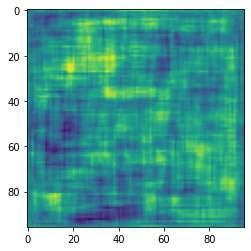

In [ ]:
# 实例化生成器，生成一张图片试试看（data view）
generator = build_generator(SEED_SIZE, IMAGE_CHANNELS)

noise = tf.random.normal([1, SEED_SIZE])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0])
plt.savefig("first_generated.jpg")

In [ ]:
# 实例化检测器，检测生成的那张试试看
image_shape = (GENERATE_SQUARE,GENERATE_SQUARE,IMAGE_CHANNELS)

discriminator = build_discriminator(image_shape)
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.4994147]], shape=(1, 1), dtype=float32)


In [ ]:
# 定义交叉熵损失函数
# 生成器和检测器
import tensorflow as tf

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
  real_loss = cross_entropy(tf.ones_like(real_output), real_output)
  # ones_like生成一个与real_output相同维度，使用1填充的tensor
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
  total_loss = real_loss + fake_loss
  return total_loss

def generator_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output), fake_output)

In [ ]:
# 使用自适应矩阵估计优化器计算每个参数的自适应学习率，进行一阶梯度优化
generator_optimizer = tf.keras.optimizers.Adam(1.5e-4, 0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(1.5e-4, 0.5)

In [ ]:
# 定义每一次的训练过程

@tf.function
# 静态编译装饰函数，把Python风格的代码转为Tensorflow计算图
def train_step(images):
  seed = tf.random.normal([BATCH_SIZE, SEED_SIZE])

  # 计算梯度下降
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    # generator生成图片
    generated_images = generator(seed, training=True)

    # discriminator判别图片真假概率
    real_output = discriminator(images, training=True)
    fake_output = discriminator(generated_images, training=True)

    # 计算损失
    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)

    # 计算梯度
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

  return gen_loss, disc_loss

In [ ]:
# 训练过程
def train(dataset, epochs):
  fixed_seed = np.random.normal(0, 1, (PREVIEW_ROWS * PREVIEW_COLS, SEED_SIZE))
  start = time.time()

  for epoch in range(epochs):
    epoch_start = time.time()

    gen_loss_list = []
    disc_loss_list = []

    for image_batch in dataset:
      t = train_step(image_batch)
      gen_loss_list.append(t[0])
      disc_loss_list.append(t[1])

    g_loss = sum(gen_loss_list) / len(gen_loss_list)
    d_loss = sum(disc_loss_list) / len(disc_loss_list)

    epoch_elapsed = time.time()-epoch_start
    print (f'Epoch {epoch+1}, gen loss={g_loss},disc loss={d_loss},'\
           ' {hms_string(epoch_elapsed)}')
    save_images(epoch,fixed_seed)

  elapsed = time.time()-start
  print (f'Training time: {hms_string(elapsed)}')

In [ ]:
# 训练检测器
train(train_dataset, EPOCHS)

# 保存检测器
generator.save(os.path.join(DATA_PATH,"face_generator.h5"))

Epoch 1, gen loss=0.6695606112480164,disc loss=1.2419767379760742, {hms_string(epoch_elapsed)}
Epoch 2, gen loss=0.6742048263549805,disc loss=1.2409229278564453, {hms_string(epoch_elapsed)}
Epoch 3, gen loss=0.6779286861419678,disc loss=1.2434254884719849, {hms_string(epoch_elapsed)}
Epoch 4, gen loss=0.6931439638137817,disc loss=1.38629150390625, {hms_string(epoch_elapsed)}
